In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append('..')

from src.data import raw_to_tokens, tokens_to_tagged, tagged_to_tokens, tagged_to_poi_street, tagged_tokens_to_onehot, get_predicted_tokens
from src import CustomTokenizer

# Import Data

In [2]:
df = pd.read_csv('../data/train.csv').set_index('id')
df['poi'], df['street'] = zip(*df['POI/street'].str.split('/'))
df['raw_tokens'] = df['raw_address'].apply(raw_to_tokens)
df['poi_tokens'] = df['poi'].apply(raw_to_tokens)
df['street_tokens'] = df['street'].apply(raw_to_tokens)
df['tagged_tokens'] = df.apply(lambda r: tokens_to_tagged(r.raw_tokens, r.poi_tokens, r.street_tokens), axis=1)


In [3]:
test = pd.read_csv('../data/test.csv').set_index('id')

In [4]:
df.head()

,raw_address,POI/street,poi,street,raw_tokens,poi_tokens,street_tokens,tagged_tokens
id,,,,,,,,
0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,"[jl, kapuk, timur, delta, sili, iii, lippo, ci...",[],"[jl, kapuk, timur, delta, sili, iii, lippo, cika]","[(jl, STREET), (kapuk, STREET), (timur, STREET..."
1,"aye, jati sampurna",/,,,"[aye,, jati, sampurna]",[],[],"[(aye,, OTHER), (jati, OTHER), (sampurna, OTHER)]"
2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,"[setu, siung, 119, rt, 5, 1, 13880, cipayung]",[],[siung],"[(setu, OTHER), (siung, STREET), (119, OTHER),..."
3,"toko dita, kertosono",toko dita/,toko dita,,"[toko, dita,, kertosono]","[toko, dita]",[],"[(toko, POI), (dita,, OTHER), (kertosono, OTHER)]"
4,jl. orde baru,/jl. orde baru,,jl. orde baru,"[jl., orde, baru]",[],"[jl., orde, baru]","[(jl., STREET), (orde, STREET), (baru, STREET)]"


In [5]:
df['tokens_onehot'] = df['tagged_tokens'].apply(tagged_tokens_to_onehot)

# Tokenize data

In [6]:
sample=df #define sample size
train, valid = train_test_split(sample, test_size=0.1, random_state=42)

In [7]:
texts = sample.raw_address.tolist() + test.raw_address.tolist()
len(texts)

350000

In [8]:
tokenizer = CustomTokenizer.CustomTokenizer(train_texts = texts)
tokenizer.train_tokenize()

In [9]:
len(tokenizer.tokenizer.word_index.items())

88307

In [10]:
reverse_word_map = dict(map(reversed, tokenizer.tokenizer.word_index.items()))

In [11]:
tokenized_X_train = tokenizer.vectorize_input(train['raw_address'])
tokenized_X_train.shape

(270000, 30)

# Build and train model

In [12]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout

In [13]:
num_tokens = len(tokenizer.tokenizer.word_index)+1
latent_dim = 128
batch_size = 256
epochs = 10

In [14]:
input_data = tokenized_X_train
output_data = CustomTokenizer.pad_sequence_tokens(train.tokens_onehot)

In [15]:
input_layer = Input(shape=(None,),name='input')
x = Embedding(num_tokens, latent_dim,name='embedding')(input_layer)
lstm_layer = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True), name='bidirectional_lstm')
output,_,_,_,_ =lstm_layer(x)
dropout_layer = Dropout(0.5, name='dropout')
output = dropout_layer(output)
dense_layer = Dense(3, activation='softmax', name='dense')
output = dense_layer(output)

model = Model(input_layer, output)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history=model.fit(input_data, output_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/10
844/844 [==============================] - 273s 312ms/step - loss: 0.1551 - val_loss: 0.1045
Epoch 2/10
844/844 [==============================] - 261s 310ms/step - loss: 0.1018 - val_loss: 0.0996
Epoch 3/10
844/844 [==============================] - 249s 295ms/step - loss: 0.0958 - val_loss: 0.0974
Epoch 4/10
844/844 [==============================] - 246s 291ms/step - loss: 0.0920 - val_loss: 0.0960
Epoch 5/10
844/844 [==============================] - 188s 223ms/step - loss: 0.0885 - val_loss: 0.0949
Epoch 6/10
844/844 [==============================] - 131s 156ms/step - loss: 0.0855 - val_loss: 0.0944
Epoch 7/10
844/844 [==============================] - 132s 156ms/step - loss: 0.0835 - val_loss: 0.0946
Epoch 8/10
844/844 [==============================] - 139s 164ms/step - loss: 0.0807 - val_loss: 0.0941
Epoch 9/10
844/844 [==============================] - 138s 164ms/step - loss: 0.0786 - val_loss: 0.0952
Epoch 10/10
844/844 [==============================] - 136s 161m

In [26]:
model.save('../model/seq_to_seq_tagging')

INFO:tensorflow:Assets written to: ../model/seq_to_seq_tagging\assets


INFO:tensorflow:Assets written to: ../model/seq_to_seq_tagging\assets


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11303424  
_________________________________________________________________
bidirectional_lstm (Bidirect [(None, None, 256), (None 263168    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense (Dense)                (None, None, 3)           771       
Total params: 11,567,363
Trainable params: 11,567,363
Non-trainable params: 0
_________________________________________________________________


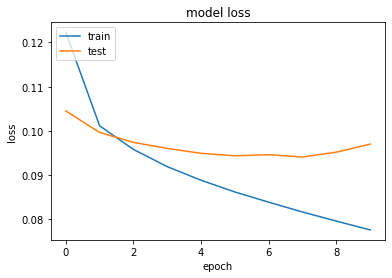

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference on Validation set

In [19]:
tokenized_X_valid = tokenizer.vectorize_input(valid['raw_address'])

In [20]:
def predict(tokenized_list, df):
    softmax = model.predict(tokenized_list)
    pred = np.argmax(softmax, axis=-1)
    return pred.tolist()

In [21]:
valid['pred'] = predict(tokenized_X_valid,valid)
valid['reverse_raw_tokens'] = tokenizer.reverse_tokenized_to_array_text(tokenized_X_valid)

D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
valid['pred_POI/street'] = valid.apply(lambda x: get_predicted_tokens(x['pred'], x['reverse_raw_tokens']), axis=1)

D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
valid[['POI/street','pred_POI/street']]

,POI/street,pred_POI/street
id,,
4941,hadi/raya kre,/
51775,pemberdayaan kesejahteraan keluarga sudajaya h...,pemberdayaan kesejahteraan/
115253,/merak 11,/merak
299321,bung karno/jl asia afrika,/jl asia afrika
173570,/kar anyar d,/kar anyar d
...,...,...
199500,/rengas,/
244038,dinas pengelola keuangan dan aset daerah/merd,dinas pengelola keuangan dan aset/
79446,/par,/


In [24]:
valid.shape

(30000, 12)

In [25]:
accuracy_score(y_true=valid['POI/street'], y_pred=valid['pred_POI/street'])

0.2898

# Inference on Test data

In [27]:
tokenized_X_test = tokenizer.vectorize_input(test['raw_address'])

In [28]:
test['pred'] = predict(tokenized_X_test, test)
test['reverse_raw_tokens'] = tokenizer.reverse_tokenized_to_array_text(tokenized_X_test)

In [29]:
test['POI/street'] = test.apply(lambda x: get_predicted_tokens(x['pred'], x['reverse_raw_tokens']), axis=1)

In [30]:
test[['raw_address','POI/street']]

,raw_address,POI/street
id,,
0,s. par 53 sidanegara 4 cilacap tengah,/s par
1,"angg per, baloi indah kel. lubuk baja",/angg
2,"asma laun, mand imog,",asma/imog
3,"ud agung rej, raya nga sri wedari karanganyar",ud agung/raya nga
4,"cut mutia, 35 baiturrahman",/cut mutia
...,...,...
49995,toko mbak farid semboro semboro,toko mbak farid/
49996,"vie - tk. ridho kids, vete 3 cari, 16720 ciawi",tk ridho kids/
49997,"mart dan roti bakar malabar, nasio,",mart dan roti bakar/


In [31]:
# Save prediction
test['POI/street'].to_csv('../data/pred.csv')